## Preparations

In [1]:
# imports
from transformers import pipeline, Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pprint import pprint
import math
from tqdm import tqdm
import time
import os
import shutil

In [2]:
# device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [3]:
def get_image(image_path):
    image = Image.open(image_path).convert("RGB")
    # image = np.array(image.convert("RGB"))
    return image

In [4]:
def show_images(images, titles, rows=2, figsize=(15, 5)):
    """
    Display a list of PIL images with corresponding titles in a grid.

    Parameters:
    - images: List of PIL.Image objects
    - titles: List of strings (titles for each image)
    - rows: Number of rows in the grid
    - figsize: Size of the overall figure (width, height)
    """
    assert len(images) == len(
        titles
    ), "The number of images and titles must be the same."

    n_images = len(images)
    cols = math.ceil(n_images / rows)

    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
def get_messages(image, system_prompt):

    return [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_prompt},
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
            ],
        },
    ]

In [6]:
def generate_output(
    model, processor, messages: list[list[dict]] | list[dict]
) -> list[str]:

    if isinstance(messages[0], dict):
        messages = [messages]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=text,
        images=image_inputs,
        videos=video_inputs,
        padding="longest",
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=1)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )
    return output_text

In [7]:
def make_classifications(images, model, processor, system_prompt) -> list[bool]:
    outputs = []
    messages_batch = []

    for image in images:
        messages = get_messages(image, system_prompt)
        messages_batch.append(messages)

    for messages in messages_batch:
        output = generate_output(model, processor, messages)
        outputs.append(output[0] == "1")
    return outputs

In [8]:
def extract_bboxes_from_image(
    pil_image,
    bboxes,
    padding_pixels,
    bbox_broaden=0,
    outline_color="red",
    outline_width=2,
):
    """
    Extracts crops from the input image corresponding to the provided bounding boxes.
    For each bounding box (in XYWH format), the function:
      1. Expands it by `padding_pixels` on all sides (clipping to image boundaries) to form a crop.
      2. Draws a rectangle on the crop corresponding to the original bbox, broadened by
         `bbox_broaden` pixels (line width = `outline_width`, color = `outline_color`).

    Args:
        pil_image (PIL.Image.Image): The source image.
        bboxes (list of tuples): List of bounding boxes, each represented as (x, y, width, height).
        padding_pixels (int): Number of pixels to pad on each side when cropping.
        bbox_broaden (int): Additional pixels to broaden the drawn bounding box.
        outline_color (str or tuple): Color used to draw the rectangle outline.
        outline_width (int): Width of the rectangle outline in pixels.

    Returns:
        list of PIL.Image.Image: A list of cropped images with drawn bounding boxes.
    """
    result_images = []

    for bbox in bboxes:
        x, y, w, h = bbox

        # Define crop region with padding
        left = max(x - padding_pixels, 0)
        top = max(y - padding_pixels, 0)
        right = min(x + w + padding_pixels, pil_image.width)
        bottom = min(y + h + padding_pixels, pil_image.height)

        crop = pil_image.crop((left, top, right, bottom))

        # Translate bbox to crop-local coordinates
        orig_box = (x - left, y - top, x - left + w, y - top + h)

        # Apply broadening and clip to crop dimensions
        red_box = (
            max(orig_box[0] - bbox_broaden, 0),
            max(orig_box[1] - bbox_broaden, 0),
            min(orig_box[2] + bbox_broaden, crop.width),
            min(orig_box[3] + bbox_broaden, crop.height),
        )

        draw = ImageDraw.Draw(crop)
        draw.rectangle(red_box, outline=outline_color, width=outline_width)

        result_images.append(crop)

    return result_images

In [9]:
def get_image_and_bboxes(image_path):
    image = get_image(image_path)
    bboxes = pd.read_csv(
        image_path.parent.parent / "csv" / image_path.with_suffix(".csv").name
    )
    bboxes = bboxes[["X", "Y", "W", "H"]].to_numpy()
    return image, bboxes

## Global variables

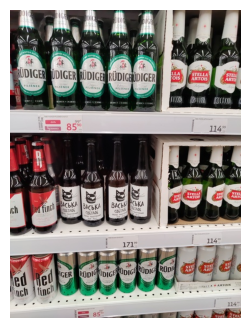

In [10]:
# DATA_PATH = Path("data")
# downloaded_dir = DATA_PATH / "downloaded"
DATA_PATH = Path(r"C:\prog\py\piv\dataset_raw")

downloaded_dir = DATA_PATH / "my_group"
image_paths = list(downloaded_dir.iterdir())

image = get_image(image_paths[0])
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(image);

In [11]:
shelf_classification_system_prompt = 'Describe the image. If the image is a real photo (not a drawing or illustration), and it shows only a shelf with drinks inside a store, with no unrelated or foreign objects, and it is not a bar stand, respond with "1". Otherwise, respond with "0".'
bbox_classification_system_prompt = 'Look at the image and focus on the object inside the red box. If the red box contains the entire bottle or can of any drink (not just a small part of it), respond with "1". If it shows only a partial view or it is not a bottle or can of a drink, respond with "0".'

model_name = "Qwen/Qwen2.5-VL-7B-Instruct"

In [12]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
    attn_implementation="sdpa",
)
# min_pixels = 10 * 10
# max_pixels = 400 * 400
processor = AutoProcessor.from_pretrained(model_name, use_fast=True)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
def classification_pipeline(
    image_paths, model, processor, system_prompt, num_of_samples=None
) -> list[bool]:
    image_paths = image_paths[:num_of_samples]
    batch_size = 10
    outputs = []
    with tqdm(total=len(image_paths)) as progress_bar:
        for i in range(0, len(image_paths), batch_size):
            images_batch = [
                get_image(img_path) for img_path in image_paths[i : i + batch_size]
            ]

            output = make_classifications(images_batch, model, processor, system_prompt)

            outputs.extend(output)
            progress_bar.update(len(images_batch))

    return outputs

In [14]:
# labels = classification_pipeline(
#     image_paths, model, processor, shelf_classification_system_prompt, 3
# )

In [15]:
# deleted_dir = DATA_PATH / "deleted"
# os.makedirs(deleted_dir, exist_ok=True)

# for path, label in zip(image_paths, labels):
#     if label == False:
#         # path = path.parent.parent / "csv" / path.with_suffix(".csv").name
#         shutil.move(path, deleted_dir / path.name)
# #
# print(f"{len(labels) - sum(labels)} files were deleted")

In [16]:
def bbox_verification_pipeline(
    image_paths, model, processor, system_prompt, num_of_samples=None
):
    image_paths = image_paths[:num_of_samples]
    with tqdm(total=len(image_paths)) as progress_bar:
        for image_path in image_paths:
            image, bboxes = get_image_and_bboxes(image_path)
            cropped_images = extract_bboxes_from_image(
                image, bboxes, padding_pixels=10, outline_width=2, bbox_broaden=4
            )
            labels = make_classifications(
                cropped_images, model, processor, system_prompt
            )
            true_bboxes = bboxes[labels]
            pd.DataFrame(true_bboxes, columns=["X", "Y", "W", "H"]).to_csv(
                image_path.parent.parent / "csv" / image_path.with_suffix(".csv").name
            )
            progress_bar.update(1)

In [ ]:
bbox_verification_pipeline(
    image_paths[:], model, processor, bbox_classification_system_prompt
)

100%|██████████| 257/257 [1:30:57<00:00, 21.23s/it]


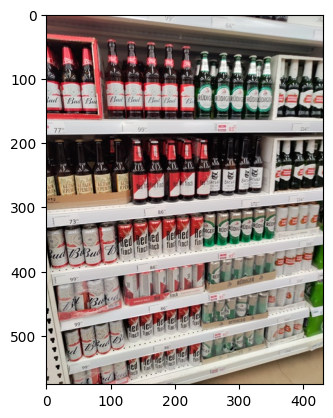

In [18]:
img, bbxs = get_image_and_bboxes(image_paths[2])
plt.imshow(img)
plt.show()

In [19]:
bbxes = extract_bboxes_from_image(img, bbxs, 10, outline_width=2, bbox_broaden=4)

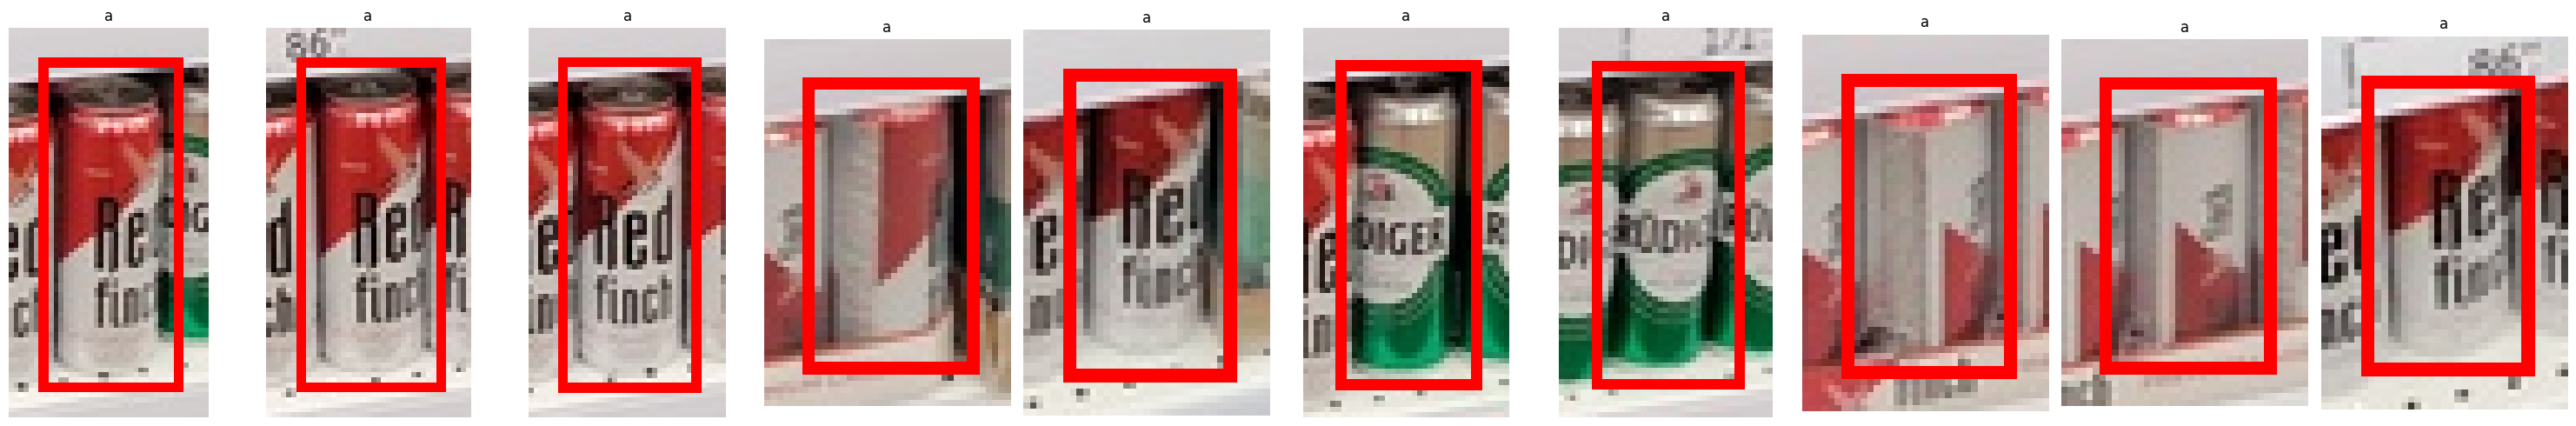

In [20]:
a = 10
show_images(bbxes[:a], ["a"] * a, rows=1, figsize=(30, 5))

In [21]:
labels = make_classifications(
    bbxes[:30], model, processor, bbox_classification_system_prompt
)

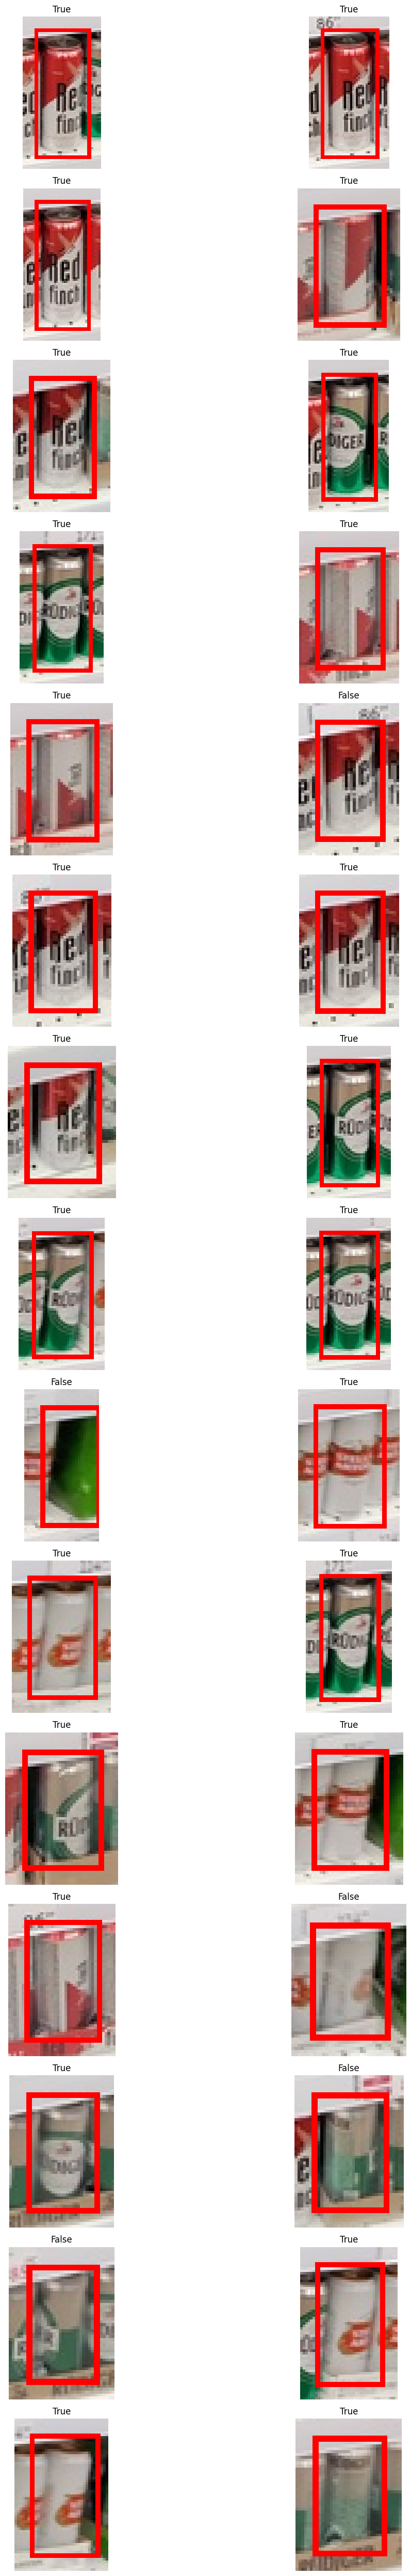

In [22]:
imgs = bbxes[:30]
show_images(imgs, labels, rows=15, figsize=(15, 50))

In [ ]:
pd.DataFrame(bbxs, columns=["X", "Y", "W", "H"])

,x,y,w,h
0,57,177,15,53
1,86,174,12,50
2,91,245,12,54
3,122,170,11,47
4,72,176,13,51
...,...,...,...,...
65,443,124,35,90
66,118,107,11,41
67,247,235,20,84
68,189,119,9,26
